# Notebook 2: CNF com Trace Exato

Este notebook implementa CNF completo com cálculo de log-likelihood via change of variables.

## Objetivos:
1. Implementar divergence_exact e CNF
2. Treinar em dados 2D e MNIST reduzido
3. Comparar com Real NVP baseline
4. Analisar escalabilidade


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import torch
import torch.optim as optim
from src.models.cnf import CNF
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, MNISTReduced, get_dataloader
from src.utils.training import train_cnf
from src.utils.visualization import plot_data_distribution, plot_transformation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. CNF em Dados 2D


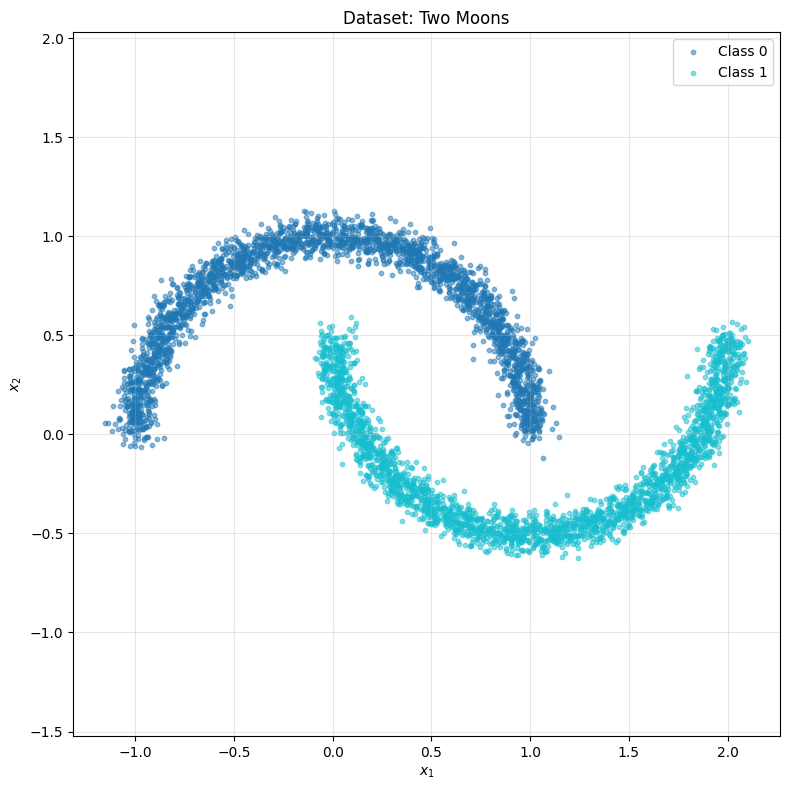

Treinando CNF em dados 2D...


Epoch 1/5: 100%|██████████| 40/40 [00:05<00:00,  7.12it/s]


Epoch 1, Loss: 2.1176


Epoch 2/5: 100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 2, Loss: -0.4590


Epoch 3/5: 100%|██████████| 40/40 [00:10<00:00,  3.67it/s]


Epoch 3, Loss: -9.9602


Epoch 4/5: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s]


Epoch 4, Loss: -29.9615


Epoch 5/5:  48%|████▊     | 19/40 [00:12<00:14,  1.48it/s]


KeyboardInterrupt: 

In [2]:
# Criar dataset 2D
dataset_2d = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader_2d = get_dataloader(dataset_2d, batch_size=128, shuffle=True)

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data_distribution(
    dataset_2d.data,
    labels=dataset_2d.labels,
    ax=ax,
    title="Dataset: Two Moons"
)
plt.tight_layout()
plt.show()

# Criar e treinar CNF
vf_2d = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d).to(device)
optimizer_2d = optim.Adam(cnf_2d.parameters(), lr=1e-3)

print("Treinando CNF em dados 2D...")
train_cnf(cnf_2d, dataloader_2d, optimizer_2d, device, num_epochs=5)

# Avaliar log-likelihood
cnf_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    log_probs = cnf_2d.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")


## 1.1. Visualizar Transformação CNF

Visualização das trajetórias que transformam amostras da distribuição base (z ~ N(0,I)) em amostras do dataset (x).


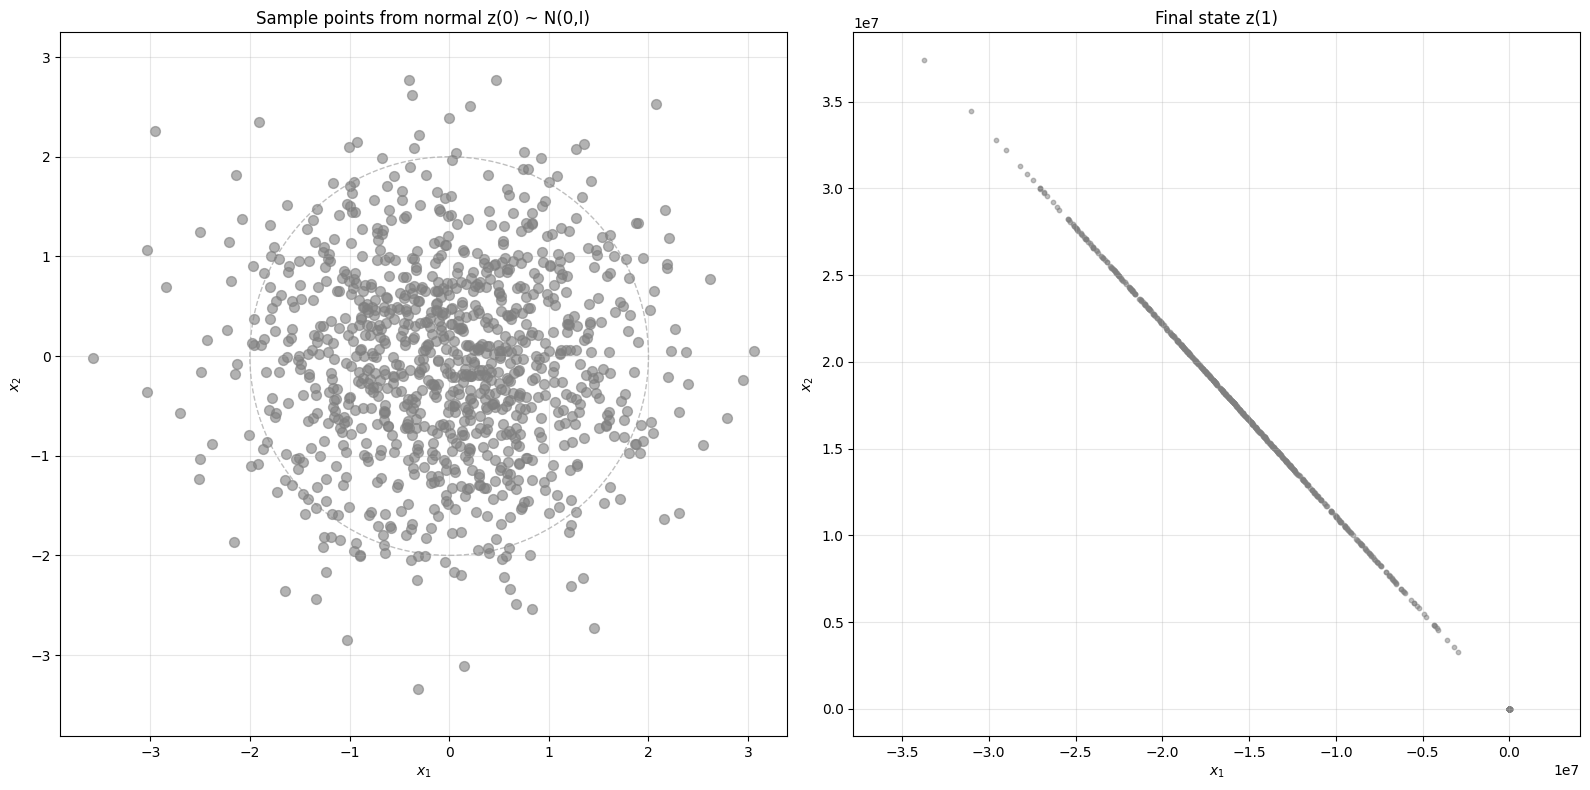

In [4]:
plot_transformation(
    cnf_2d,
    n_samples=1000,
    n_trajectory_points=100
)
plt.tight_layout()
plt.show()

## 2. CNF em MNIST Reduzido


In [ ]:
# Criar dataset MNIST reduzido (100 dimensões)
print("Carregando MNIST reduzido...")
dataset_mnist = MNISTReduced(train=True, n_components=100)
dataloader_mnist = get_dataloader(dataset_mnist, batch_size=128, shuffle=True)

# Criar e treinar CNF
vf_mnist = VectorField(features=100, hidden_dims=[128, 128], time_embed_dim=32)
cnf_mnist = CNF(vf_mnist).to(device)
optimizer_mnist = optim.Adam(cnf_mnist.parameters(), lr=1e-3)

print("Treinando CNF em MNIST reduzido...")
start_time = time.time()
train_cnf(cnf_mnist, dataloader_mnist, optimizer_mnist, device, num_epochs=5)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
cnf_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    log_probs = cnf_mnist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = cnf_mnist.sample(1000)
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")


## 3. Análise de Escalabilidade

**Por que trace exato não escala para MNIST completo (784 dim)?**

- Custo computacional: O(d²) onde d é a dimensão
- Para d=784: precisamos de 784 backward passes
- Cada backward é O(784) → Total O(784²) = O(614,656)
- Isso é muito lento para treinamento prático!

**Solução:** Usar Hutchinson trace estimator (FFJORD) - O(d)
